### Machine Learning
## Data Preparation
For the purposes of better functionality, this notebook was not based on the corresponding CBR-teaching notebook, but rather adapted from several talktorials from 'teachopencadd'.

Firstly, all necessary Python libraries are imported, also including the ChEMBL webresource client.

In [1]:
import math
from zipfile import ZipFile
from tempfile import TemporaryDirectory

from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

import os
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit

# from teachopencadd.utils import seed_everything

# originally from the Volkamerlab teachopencadd github
# but has been deleted since. This is the code for the original function.

def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [2]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


Below, resource objects for API access are created.

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [4]:
# uniprot_id = "P00533" EGFR kinase 
uniprot_id = "P35354" # Cyclo oxygenase 2 (COX2)

# Fetching COX2 target data from ChEMBL

In [5]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


# Fetching COX2 bioactivity data for the target from ChEMBL

Here, the bioactivity data for COX2 is fetched and filtered to contain:

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [6]:
chembl_id = 'CHEMBL230' #CHEMBL230 is COX2

In [7]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 5178, <class 'chembl_webresource_client.query_set.QuerySet'>


Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells starting from _"Fetch bioactivity data for the target from ChEMBL"_

The cell below generates a dataframe, which in this case should contain 5179 entries. As well as that, it removes both the "units" and "values" columns, since we will only be working with the standardized units and values from this point onwards.

In [8]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (5179, 11)


# Preprocessing and filtering the fetched bioactivity data

Here, we make sure the data in the dataframe is usable for the project. In order to achieve this, `standard_value`'s datatype is changed from `object` to `float`. As well as that, entries with missing values, entries without "nM" as `standard_unit` and duplicate entries are deleted. To round off the `DataFrame` index is reset and its columns are renamed.

In [9]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"}) # Convert 'standard value' to numeric
bioactivities_df.dropna(axis=0, how="any", inplace=True) # remove rows with missing entries
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"] # keep only nM activity entries
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,34205,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL297008,=,nM,60.00,CHEMBL230,Homo sapiens,IC50
1,34209,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL289813,=,nM,3230.00,CHEMBL230,Homo sapiens,IC50
2,35476,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL43736,=,nM,80.00,CHEMBL230,Homo sapiens,IC50
3,36218,CHEMBL769655,Tested in vitro for inhibition against Prostag...,B,CHEMBL140167,=,nM,0.12,CHEMBL230,Homo sapiens,IC50
4,39073,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL44290,=,nM,1610.00,CHEMBL230,Homo sapiens,IC50


In [10]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4020, 11)


The dataframe should now contain a total of 4020 entries.

# Obtaining compound data

A `DataFrame` containing all molecules tested against COX2 (with the respective measured bioactivity) has been generated. The next step is to fetch the molecular structures, from their (canonical) SMILES, of the molecules that are linked to respective bioactivity ChEMBL IDs. 

In [11]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [12]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/4020 [00:00<?, ?it/s]

In [13]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (4020, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL6,{'canonical_smiles': 'COc1ccc2c(c1)c(CC(=O)O)c...
1,CHEMBL25,"{'canonical_smiles': 'CC(=O)Oc1ccccc1C(=O)O', ..."
2,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
3,CHEMBL7162,{'canonical_smiles': 'CS(=O)(=O)Nc1ccc([N+](=O...
4,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...


# Preprocessing and filtering of fetched compound data

Before advancing, just as with the target data, entries with missing values and duplicate entries (based on their `molecule_chembl_id`) are deteleted. Then, molecules are obtained using canonical SMILES strings.

In [14]:
# df cleanup
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
compounds_df.iloc[0].molecule_structures.keys()

# only keep canonical smiles
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (4019, 2)


,molecule_chembl_id,smiles
0,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1
1,CHEMBL25,CC(=O)Oc1ccccc1C(=O)O
2,CHEMBL28,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
3,CHEMBL7162,CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1OC1CCCCC1
4,CHEMBL50,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12


# Output for bioactivity data with compound data

Firstly, a summary of the filtered bioactivity data and the filtered compound data is printed. Then, the values of interest from these datasets are merged into one `output_df` containing `molecule_cheml_id1`, `smiles`, `units` and `IC50` columns. The latter of these are then converted into pIC50 values to improve readability and comparability.

In [15]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 4020


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [16]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 4019


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [17]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 4019 entries.


In [18]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [19]:
# removes IC50 = 0.0 to prevent Domain Error when converting to pIC50
output_df = output_df[output_df['IC50'] != 0.0] 

# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [20]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


# Visualizing compound pIC50 data

Here, the distribution of pIC50 values within our dataset is visualized using a histogram. As well as that, the mean pIC50 value is determined.

In [142]:
output_df['pIC50'].mean()

6.1276905903286645

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

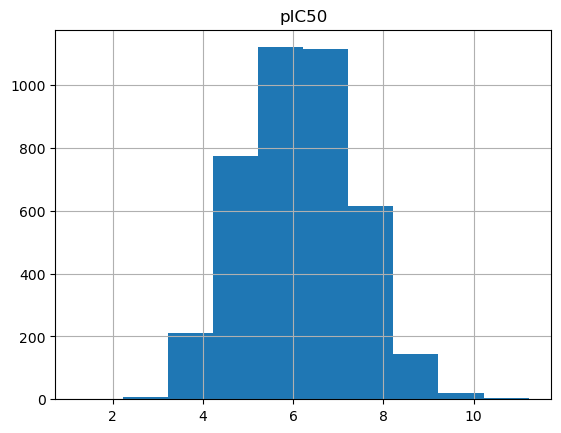

In [21]:
output_df.hist(column="pIC50")

In [22]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


Lastly, the dataframe is saved as a CSV file in order to be able to easily fetch it in future runs.

In [24]:
print(f"DataFrame shape: {output_df.shape}")
output_df.to_csv("COX2_compounds.csv")

DataFrame shape: (4012, 5)


# Calculating and plotting Lipinski Rule of 5 properties

In this step, the properties for Lipinski's rule of 5 are defined. The rule means that molecules, generally speaking, are drug-like if they have a molecular weight of under 500 Da and a logP values under 5 and contain less than 10 hydrogen bond-acceptors (`HBA`) and less than 5 hydrogen bond-donors (`HBD`).
These properties are first defined, after which a function is made to calculate them from the input molecules' SMILES strings.  

In [25]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

In [26]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

Here, the `calculate_ro5_properties` function is applied to the COX2 dataset in order to determine the molecules' compliance to Lipinski's Rule of 5. For this, the dataset is first downloaded from the previously generated CSV file. 
Lastly, the compounds in the dataset are filtered based on their compliance, after which a new CSV file is generated containing only the compliant molecules.

In [27]:
molecules = pd.read_csv("COX2_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(4012, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


In [28]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)

# add ro5 column to df
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


In [29]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 4012
# compounds in filtered data set: 3749
# compounds not compliant with the Ro5: 263


In [30]:
# Save filtered data
molecules_ro5_fulfilled.to_csv("COX2_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


# Using radar plots to visualize Lipinski's Rule of 5-properties

After a helper function is defined to determine mean and standard deviation values for a dataframe, it is used on the dataframe with molecules that comply with the rule of 5. Seperately, we use the same helper function on the dataset with molecules that violate the rule of 5 as well.

In [31]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

Firstly, the results for the dataset of compounds that are __fulfilling the Ro5__:

In [32]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,380.067665,70.112775
n_hba,4.747933,1.813385
n_hbd,0.990397,1.020031
logp,3.736006,1.368813


And for the dataset of compounds that are __violating the Ro5__:

In [33]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,659.275407,305.417410
n_hba,9.939163,8.815978
n_hbd,2.673004,5.394328
logp,5.354362,3.676486


In the following, a few helper functions are defined to be used for radar plotting. For an equal radar plot, all values need to have the same scale. Therefore, all rules within Lipinski's rule of 5 need to be modified to a scale treshold of five. This means `HBD` and `LogP` can stay as they are, whereas `HBA` needs to be divided by 10/5=2 and `MWT` needs to be divided by 500/5=100. The first helper function performs these modifications.

In [34]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

The second helper function, found below, defines the axes for the radar graph. In our case, the graph needs to showcase four properties, meaning they have to be set at 0°, 90°, 180°, and 270° for an equal graph. This helper function returns such angles as radians. Combined with the helper function above, this function will be used for the final radar plots.

In [35]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

The function below defines what is needed to visualize the compounds' chemical properties in the form of a radar chart. For this function, [these instructions on stackoverflow were used](https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot). After that, the input parameters for the rule of 5 characteristics are defined, which will be used for a radar plot for the rule of 5-compliant dataset, as well as for a radar plot for the rule of 5-violating dataset.

In [36]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    # y = y.append(y.iloc[0])

    first_row = y.iloc[[y.index.get_loc('molecular_weight')]] # .append() method is outdated op df's, dus hier omgeschreven - Wessel
    y = pd.concat([y, first_row])
    
    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("rule of five area", "mean", "mean + std", "mean - std")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [37]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

The first plot that is generated, is the radarplot for the dataset of compounds that __fulfill the rule of 5__:

In [38]:
pd.concat([molecules_ro5_fulfilled_stats, molecules_ro5_fulfilled_stats.iloc[0]])

,mean,std,molecular_weight
molecular_weight,380.067665,70.112775,NaN
n_hba,4.747933,1.813385,NaN
n_hbd,0.990397,1.020031,NaN
logp,3.736006,1.368813,NaN
mean,NaN,NaN,380.067665
std,NaN,NaN,70.112775


In [39]:
df = molecules_ro5_fulfilled_stats
first_row = df.iloc[[df.index.get_loc('molecular_weight')]]
df = pd.concat([df, first_row])
df

,mean,std
molecular_weight,380.067665,70.112775
n_hba,4.747933,1.813385
n_hbd,0.990397,1.020031
logp,3.736006,1.368813
molecular_weight,380.067665,70.112775


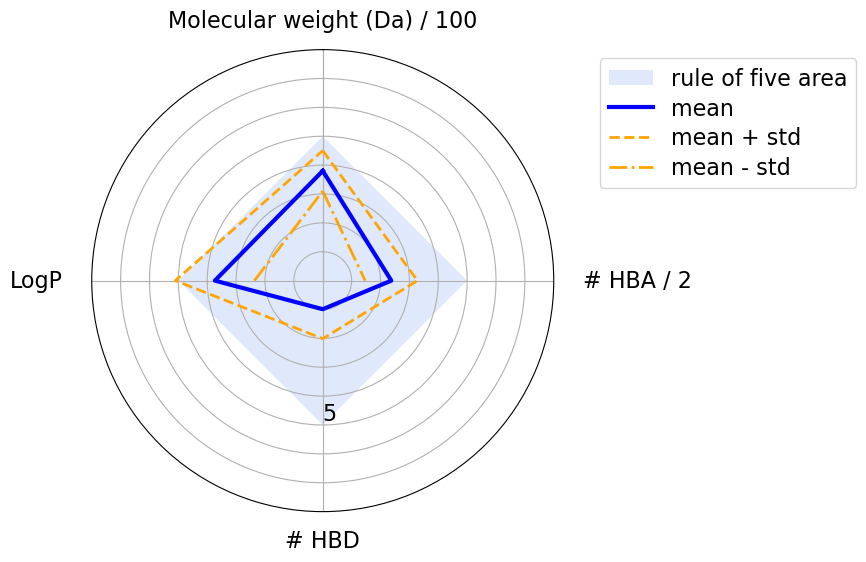

In [40]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

The blue square shows the area where a molecule's physicochemical properties are compliant with the Ro5. 
The blue line highlights the mean values, while the orange dashed lines show the standard deviations. 
We can see that the mean values never violate any of Lipinski's rules. 
However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. 
This is acceptable because, according to the Ro5, one of the four rules can be violated.

Next, we generate a radar plot that showcases the compounds that __violate the rule of 5__:

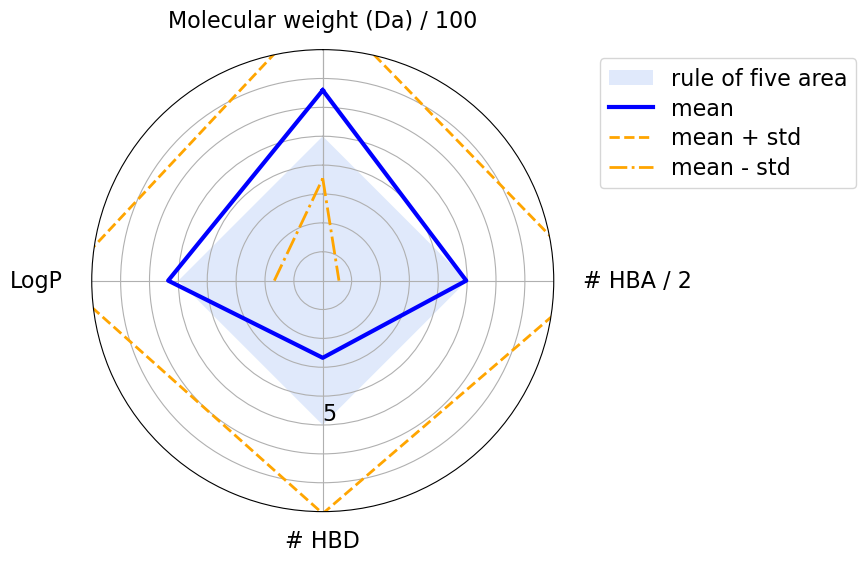

In [41]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

This graph shows that the compounds mostly violate the Ro5 because of their molecular weight, though every aspect is violated when standard deviation is taken into account.

## Machine learning

# Loading compound and activity data

To start the machine learning part, the CSV file containing the molecules compliant with Lipinski's rule of 5 is loaded into a dataframe. In this dataframe, we use the columns `molecule_chembl_id`, `smiles` and `pIC50`. After first downloading the data, histograms are generated to show the distribution of rule of 5-property values among the compounds in the dataset, after which a dataframe is generated with only the columns mentioned above.  

In [147]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    "COX2_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3749, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


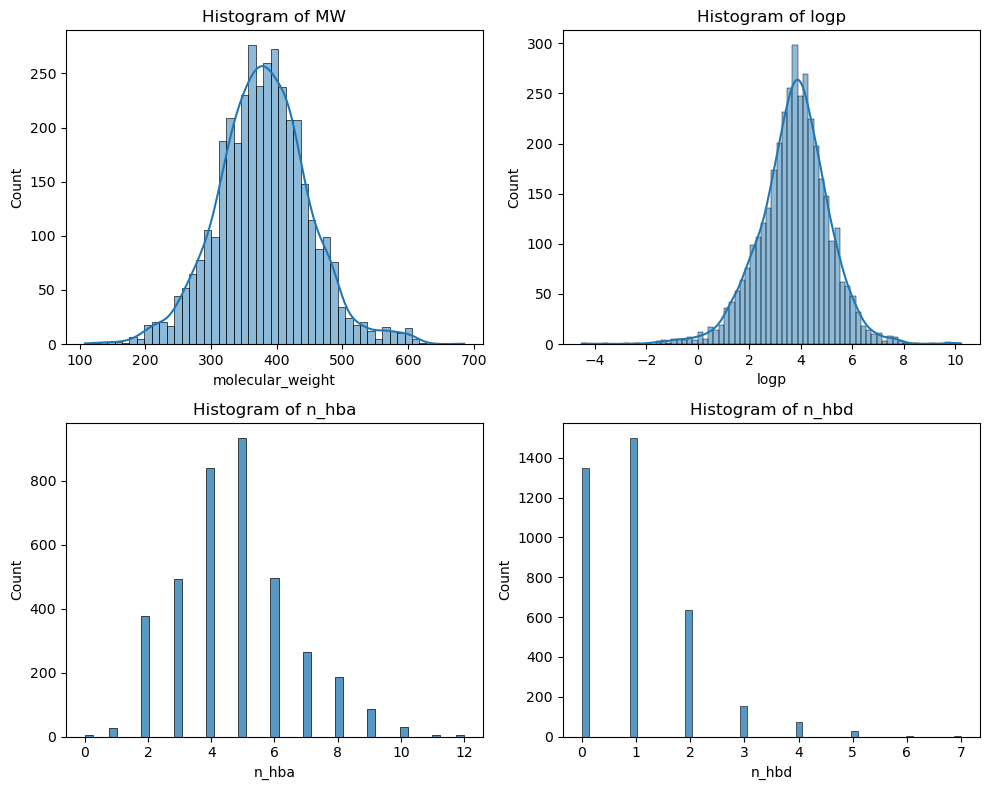

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming chembl_df is already loaded and contains the required columns

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for each column
sns.histplot(chembl_df['molecular_weight'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Histogram of MW')

sns.histplot(chembl_df['logp'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Histogram of logp')

sns.histplot(chembl_df['n_hba'], ax=axes[1, 0], kde=False)
axes[1, 0].set_title('Histogram of n_hba')

sns.histplot(chembl_df['n_hbd'], ax=axes[1, 1], kde=False)
axes[1, 1].set_title('Histogram of n_hbd')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [146]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


# Data preparation

Before further preparing the data for machine learning, the activity of the compounds within the dataset is first determined, based on their pIC50 values. Within this research, a cut-off pIC50 value of 6.3 is used, meaning all compounds with a pIC50 lower than 6.3 are considered inanctive ([<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611) and
[notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb)). Based on this, a column is added for activity, in which every compound is given a value of 1.0 ("active") or 0.0 ("inactive") for activity labeling. 

In [44]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 1695
Number of inactive compounds: 2054


In [45]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,1.0
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,0.0


Next, the function `smiles_to_fp` is defined to generate fingerprints from SMILES. Within this run, MACCS fingerprints (`maccs`) were used for this, however, the function also has definitions for Morgan fingerprints with radiuses of 2 (`morgan2`) and 3 (`morgan3`). A column for these generated fingerprints is then added to the existing dataframe.

In [46]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    # if method == 'morganX':
    #     mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    #     return np.array(mfpgen.GetFingerprint(smiles))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [47]:
compound_df = chembl_df.copy()

In [48]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Machine Learning models

In the following, we will try three different Machine Learning approaches to classify our molecules: Random Forests (RF), Support Vector Machines (SVM) and Artificial Neural Networks (ANN). These models will be assessed in terms of their performance to determine which one is the most useful and predictive for COX2. 

Firstly, some helper functions are defined, which, in order, help plot customized ROC curves ([stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python)), calculate model performance and fit a model on a random data split and return performance measures.

In [49]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [50]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [51]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In the cell below, the data is preprocessed through defining and determining a random training/test data split.

In [52]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2999
Test data size: 750


The first Machine Learning model to be tested, is a __Random Forest (RF)__. After setting the parameters, the model is trained on a single random train/test split and a Receiver Operating Characteristic (ROC) curve plot is generated to show model performance. ROC curves for the other Machine Learning models will be added to this graph later on. 

In [53]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [54]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.78
Specificity: 0.80
AUC: 0.86


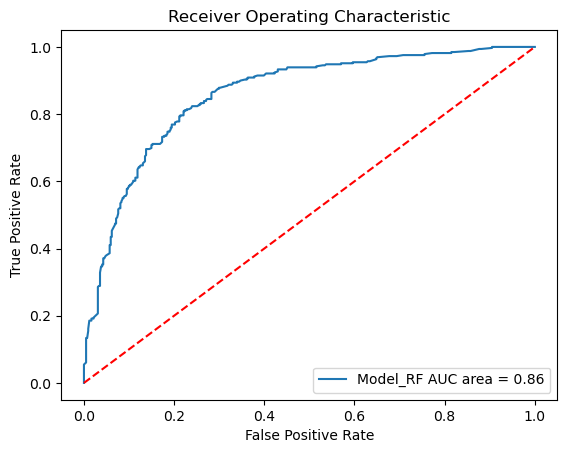

In [55]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

Secondly, a Machne Learning Model for __Support Vector Machines (SVM)__ is generated in a similar fashion. This is done with a radial-basis function kernel (also: squared-exponential kernel, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html). The ROC curve for the SVM model is then added to the graph with the RF ROC curve.

In [56]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.77
Specificity: 0.82
AUC: 0.86


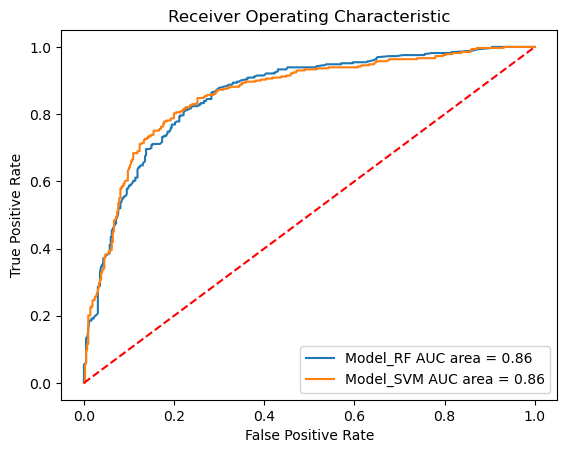

In [57]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

The last Machine Learning model we try here is an __Artificial Neural Network (ANN)__ model. For this, we train an MLPClassifier (Multi-layer Perceptron classifier, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with 2 layers: the first layer with 5 neurons and the second layer with 3 neurons. The results for this model were added to the combined ROC curve graph as well, to showcase a performance comparison between the three tested Machine Learning models.

In [58]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.68
Specificity: 0.82
AUC: 0.81


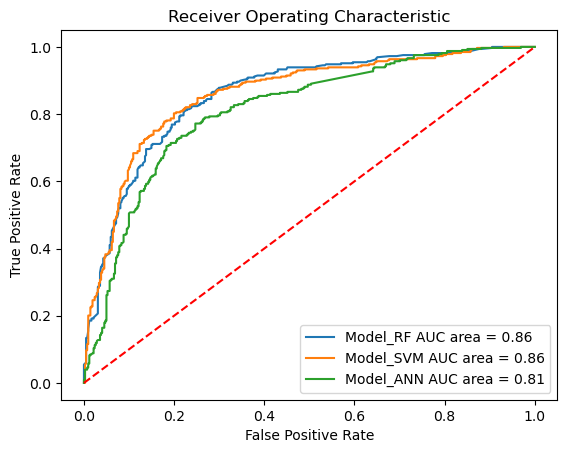

In [59]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

Based on this model, all three methods seem to be predictive from their model performance, though the AUC for ANN is just lower than the others' AUCs. Since the used dataset is not too large, though, it is to be wondered how conclusive such a minor difference is. 

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [60]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [161]:
N_FOLDS = 5

_Note_: Next cell takes long to execute

In [162]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.81 	and std : 0.02 
Mean sensitivity: 0.79 	and std : 0.04 
Mean specificity: 0.83 	and std : 0.03 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 11.34s


Model_SVM
Mean accuracy: 0.78 	and std : 0.01 
Mean sensitivity: 0.63 	and std : 0.04 
Mean specificity: 0.90 	and std : 0.02 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 458.32s


Model_ANN
Mean accuracy: 0.77 	and std : 0.01 
Mean sensitivity: 0.75 	and std : 0.02 
Mean specificity: 0.78 	and std : 0.02 
Mean AUC: 0.83 	and std : 0.01 
Time taken : 239.84s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [63]:
# Reset data frame
compound_df = chembl_df.copy()

In [64]:
%%capture
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

_Note_: Next cell takes long to execute

In [65]:
for model in models:
    #if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        #continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.78 	and std : 0.01 
Mean specificity: 0.83 	and std : 0.02 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 5.87s


Model_SVM
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.59 	and std : 0.03 
Mean specificity: 0.91 	and std : 0.02 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 215.11s


Model_ANN
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.75 	and std : 0.01 
Mean specificity: 0.77 	and std : 0.03 
Mean AUC: 0.83 	and std : 0.01 
Time taken : 160.67s



In [66]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pIC50.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pIC50.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [67]:
compound_df

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
4014,CHEMBL5290904,CS(=O)(=O)c1ccc(-c2cn3c(c2-c2ccccc2)CCC3)cc1,7.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4015,CHEMBL5277274,COC1c2c(-c3ccccc3)c(-c3ccc(Cl)cc3)c(C)n2CC1(C)C,5.124939,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4016,CHEMBL5272932,Cc1ccc(-c2cn3c(c2-c2ccccc2)CCC3)s1,5.744727,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4017,CHEMBL4472111,CCOC(=O)[C@H](CO)NC(=O)c1cccc(O)c1O,5.653647,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [68]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pIC50.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2999
Test data size: 750


In [69]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.61 	and std : 0.01 
RMSE: 0.82 	and std : 0.02 



You will notice that we report different measures of accuracy. We no longer deal with categorical data so we now look at the errors between experimental data and predicted data using the MAE and RMSE. Typically, an MAE below 0.6 and/or RMSE below, approximately, is considered quite decent.

Next, let's use the RF model to run predictions on a new compound. You can design your compounds in a sketcher (chemdraw (https://chemdrawdirect.perkinelmer.cloud/js/sample/index.html#) or an online tool).

In [166]:
sallikes = pd.read_csv('sallikes.csv')
sallikes.head()

,ligand_code,beschrijving,SMILES,Vina_Affinity,Vina_pCHEMBL,ML_pCHEMBL
0,ligand_00,sal,OC1=CC=CC=C1C(O)=O,-5.755,4.22,4.92
1,ligand_02,"sal alt, pyridine en methoxy pose 4",O=C(O)C1=CC=NC=C1OC,-4.656,3.42,5.56
2,ligand_03,sal alt extra ring pose 0,OC1=CC=C2C(C=CC2)=C1C(O)=O,-5.810,4.26,5.47
3,ligand_04,phtalic acid,C1=CC=C(C(=C1)C(=O)O)C(=O)O,-5.332,3.91,4.93
4,ligand_05,sal alt met N ipv O (aminobenzeenzuur),NC1=CC=CC=C1C(O)=O,-5.476,4.02,5.06


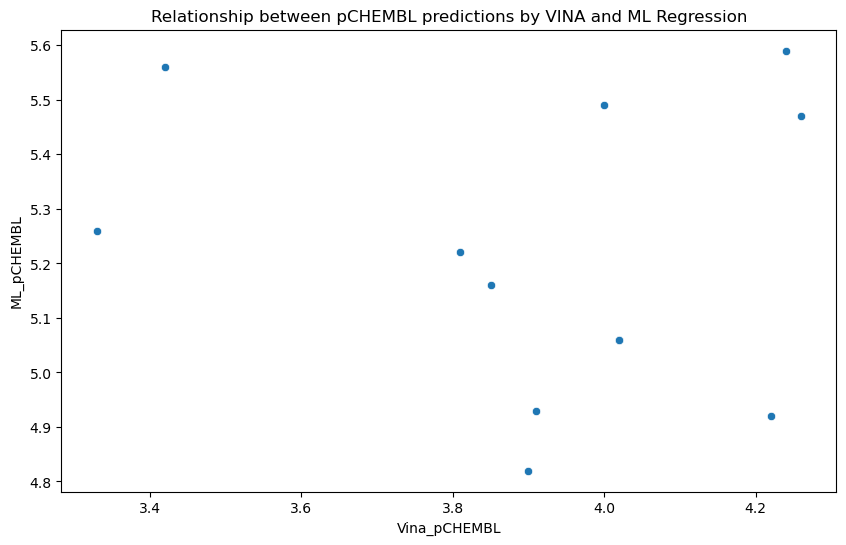

Correlation Coefficient: -0.08844057468600999


In [168]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Vina_pCHEMBL', y='ML_pCHEMBL', data=sallikes)

# Add title and labels
plt.title('Relationship between pCHEMBL predictions by VINA and ML Regression')
plt.xlabel('Vina_pCHEMBL')
plt.ylabel('ML_pCHEMBL')

# Show the plot
plt.show()

# Calculate and display correlation coefficient
correlation = sallikes['Vina_pCHEMBL'].corr(sallikes['ML_pCHEMBL'])
print(f"Correlation Coefficient: {correlation}")

In [163]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
                      
    'OC1=CC=CC=C1C(O)=O', # Salicylic acid (SAL)
    "O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl", #aclofenac
    "O=C(O)C1=CC=NC=C1OC", #sal alt 1, pyridine en methoxy
    "OC1=CC=C2C(C=CC2)=C1C(O)=O", # sal alt 2, met extra ring
    "C1=CC=C(C(=C1)C(=O)O)C(=O)O", #phtalic acid
    "NC1=CC=CC=C1C(O)=O", #sal alt met N ipv O
    "OC1=CC=CC=C1C(N)=O",  #sal alt met C(N)=O ipv C(O)=O
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N en methylgroep
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N"
    "OC1=CC=C2C(C=CC2)=C1C(O)=N", # sal alt met carbidimic acid en extra ring
    "OC1=CC(C)=C(F)C=C1C(O)=O", # sal alt met fluoride en methyl
    "OC1=CC(F)=C(F)C=C1C(O)=O", # sal alt met difluoride
    "COc1ccc2cc(CCC(C)=O)ccc2c1", #NABUMETONE
    "CCc1cccc2c3c([nH]c12)C(CC)(CC(=O)O)OCC3" #ETODOLAC
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
OC1=CC=CC=C1C(O)=O,4.92
O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,6.49
O=C(O)C1=CC=NC=C1OC,5.56
OC1=CC=C2C(C=CC2)=C1C(O)=O,5.47
C1=CC=C(C(=C1)C(=O)O)C(=O)O,4.93
NC1=CC=CC=C1C(O)=O,5.06
OC1=CC=CC=C1C(N)=O,5.05
CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,7.17
CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,7.17
OC1=CC=C2C(C=CC2)=C1C(O)=N,5.16
OC1=CC(C)=C(F)C=C1C(O)=O,5.26
OC1=CC(F)=C(F)C=C1C(O)=O,5.22
COc1ccc2cc(CCC(C)=O)ccc2c1,5.29
CCc1cccc2c3c([nH]c12)C(CC)(CC(=O)O)OCC3,5.51


[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator
[13:28:17] DEPRECATION WARNING: please use MorganGenerator


# 1: Downloaden + cleanup van COX2 data van CHEMBL

First, the ChEMBL webresource client as well as other Python libraries are imported.

In [71]:
import math
from zipfile import ZipFile
from tempfile import TemporaryDirectory

from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

import os
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit

#from teachopencadd.utils import seed_everything

# komt origineel van de Volkamerlab teachopencadd github
# maar is inmiddels verwijderd, hier de code van de originele functie - Wessel

def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [72]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


Next, we create resource objects for API access.

In [73]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [74]:
# uniprot_id = "P00533" EGFR kinase 
uniprot_id = "P35354" # Cyclo oxygenase 2 (COX2)

#### Fetch target data from ChEMBL

In [75]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [76]:
chembl_id = 'CHEMBL230' #CHEMBL230 is COX2

In [77]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 5178, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells starting from _"Fetch bioactivity data for the target from ChEMBL"_ or read this message below:

<details>
    
<summary>Load a local version of the data (in case you encounter any problems while fetching the data)</summary>
    
If you experience difficulties to query the ChEMBL database, we also provide the resulting dataframe you will construct in the cell below. If you want to use the saved version, use the following code instead to obtain `bioactivities_df`:
  
```python
# replace first line in cell below with this other line
bioactivities_df = pd.read_csv(DATA / "EGFR_bioactivities_CHEMBL27.csv.zip", index_col=0)
```

</details>

In [78]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")  # hoort df met 5179 entries te downloaden, 23 sep 2024 - Wessel

DataFrame shape: (5179, 11)


Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for `standard_units`/`units` and `standard_values`/`values`; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

If we used the `units` and `values` columns, we would need to convert all values with many different units to nM:

#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [79]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"}) # Convert 'standard value' to numeric
bioactivities_df.dropna(axis=0, how="any", inplace=True) # remove rows with missing entries
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"] # keep only nM activity entries
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,34205,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL297008,=,nM,60.00,CHEMBL230,Homo sapiens,IC50
1,34209,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL289813,=,nM,3230.00,CHEMBL230,Homo sapiens,IC50
2,35476,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL43736,=,nM,80.00,CHEMBL230,Homo sapiens,IC50
3,36218,CHEMBL769655,Tested in vitro for inhibition against Prostag...,B,CHEMBL140167,=,nM,0.12,CHEMBL230,Homo sapiens,IC50
4,39073,CHEMBL762912,In vitro inhibitory activity against human pro...,B,CHEMBL44290,=,nM,1610.00,CHEMBL230,Homo sapiens,IC50


In [80]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4020, 11)


!! **4020** voor de COX2

### Get compound data

We have a `DataFrame` containing all molecules tested against EGFR (with the respective measured bioactivity). 

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs. 

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [81]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [82]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/4020 [00:00<?, ?it/s]

In [83]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (4020, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL6,{'canonical_smiles': 'COc1ccc2c(c1)c(CC(=O)O)c...
1,CHEMBL25,"{'canonical_smiles': 'CC(=O)Oc1ccccc1C(=O)O', ..."
2,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
3,CHEMBL7162,{'canonical_smiles': 'CS(=O)(=O)Nc1ccc([N+](=O...
4,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [84]:
# df cleanup
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
compounds_df.iloc[0].molecule_structures.keys()

# only keep canonical smiles
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (4019, 2)


,molecule_chembl_id,smiles
0,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1
1,CHEMBL25,CC(=O)Oc1ccccc1C(=O)O
2,CHEMBL28,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
3,CHEMBL7162,CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1OC1CCCCC1
4,CHEMBL50,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [85]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 4020


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [86]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 4019


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [87]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 4019 entries.


As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [88]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [89]:
# removes IC50 = 0.0 to prevent Domain Error when converting to pIC50
output_df = output_df[output_df['IC50'] != 0.0] 

# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [90]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

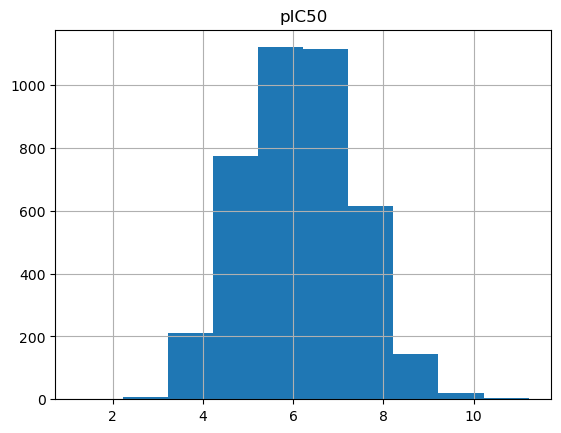

In [91]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [92]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


In [93]:
# # Prepare saving the dataset: Drop the ROMol column
# output_df = output_df.drop("ROMol", axis=1)
# print(f"DataFrame shape: {output_df.shape}")

#### Write output data to file

We want to use this bioactivity-compound dataset in the following talktorials, thus we save the data as `csv` file. 
Note that it is advisable to drop the molecule column (which only contains an image of the molecules) when saving the data.

In [94]:
print(f"DataFrame shape: {output_df.shape}")
output_df.to_csv("COX2_compounds.csv")

DataFrame shape: (4012, 5)


# T002 · Molecular filtering: ADME and lead-likeness criteria

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Michele Wichmann, CADD seminars 2017, Charité/FU Berlin
- Mathias Wajnberg, CADD seminars 2018, Charité/FU Berlin
- Dominique Sydow, 2018-2020, [Volkamer lab](https://volkamerlab.org), Charité
- Andrea Volkamer, 2018-2020, [Volkamer lab](https://volkamerlab.org), Charité

## Practical

### Define and visualize example molecules

Before working with the whole dataset retrieved from ChEMBL, we pick four example compounds to investigate their chemical properties.
We draw four example molecules from their SMILES.

First, we combine the names and SMILES of the molecules, together with their structure, in a DataFrame.

### Calculate and plot molecular properties for Ro5

1. Calculate molecular weight, number of hydrogen bond acceptors and donors, and logP using some of the [descriptors](http://www.rdkit.org/docs/GettingStartedInPython.html#descriptor-calculation) available in `rdkit`.

In [95]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

### Investigate compliance with Ro5

In [96]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

### Apply Ro5 to the COX2 dataset

The `calculate_ro5_properties` function can be applied to the EGFR dataset for Ro5-compliant compounds.

In [97]:
molecules = pd.read_csv("COX2_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(4012, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


Apply the Ro5 to all molecules.

In [98]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)

# add ro5 column to df
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


Concatenate molecules with Ro5 data.

In [99]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 4012
# compounds in filtered data set: 3749
# compounds not compliant with the Ro5: 263


In [100]:
# Save filtered data
molecules_ro5_fulfilled.to_csv("COX2_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


### Visualize Ro5 properties (radar plot)

#### Calculate statistics on Ro5 properties 

Define a helper function to calculate the mean and standard deviation for an input DataFrame.

In [101]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

We calculate the statistic for the dataset of compounds that are __fulfilling the Ro5__.

In [102]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,380.067665,70.112775
n_hba,4.747933,1.813385
n_hbd,0.990397,1.020031
logp,3.736006,1.368813


We calculate the statistic for the dataset of compounds that are __violating the Ro5__.

In [103]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,659.275407,305.417410
n_hba,9.939163,8.815978
n_hbd,2.673004,5.394328
logp,5.354362,3.676486


#### Define helper functions to prepare data for radar plotting

In the following, we will define a few helper functions that are only used for radar plotting.

__Prepare y values__: 
The properties used for the Ro5 criteria are of different magnitudes. 
The MWT has a __threshold of 500__, whereas the number of HBAs and HBDs and the LogP have __thresholds of only 10, 5, and 5__, respectively. In order to visualize these different scales most simplistically, we will scale all property values to a __scaled threshold of 5__:

`scaled property value` = `property value` / `property threshold` * `scaled property threshold`

- scaled MWT = MWT / 500 * 5 = MWT / 100
- scaled HBA = HBA / 10 * 5 = HBA / 2
- scaled HBD = HBD / 5 * 5 = HBD
- scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.

In [104]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

__Prepare x values:__
The following helper function returns the __angles of the physicochemical property axes for the radar chart__. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.

In [105]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

Both functions will be used as helper functions in the radar plotting function, which is defined next.

#### Generate radar plots, finally!

Now, we define a function that visualizes the compounds' chemical properties in the form of a radar chart. 
We followed [these instructions on stackoverflow](https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot).

In [106]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    # y = y.append(y.iloc[0])

    first_row = y.iloc[[y.index.get_loc('molecular_weight')]] # .append() method is outdated op df's, dus hier omgeschreven - Wessel
    y = pd.concat([y, first_row])
    
    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("rule of five area", "mean", "mean + std", "mean - std")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In the following, we want to plot the radar chart for our two datasets:
1. Compounds that fulfill the Ro5
2. Compounds that violate the Ro5

Define input parameters that should stay the same for both radar charts:

In [107]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

1. We plot the radarplot for the dataset of compounds that __fulfill the Ro5__.

In [108]:
pd.concat([molecules_ro5_fulfilled_stats, molecules_ro5_fulfilled_stats.iloc[0]])

,mean,std,molecular_weight
molecular_weight,380.067665,70.112775,NaN
n_hba,4.747933,1.813385,NaN
n_hbd,0.990397,1.020031,NaN
logp,3.736006,1.368813,NaN
mean,NaN,NaN,380.067665
std,NaN,NaN,70.112775


In [109]:
df = molecules_ro5_fulfilled_stats
first_row = df.iloc[[df.index.get_loc('molecular_weight')]]
df = pd.concat([df, first_row])
df

,mean,std
molecular_weight,380.067665,70.112775
n_hba,4.747933,1.813385
n_hbd,0.990397,1.020031
logp,3.736006,1.368813
molecular_weight,380.067665,70.112775


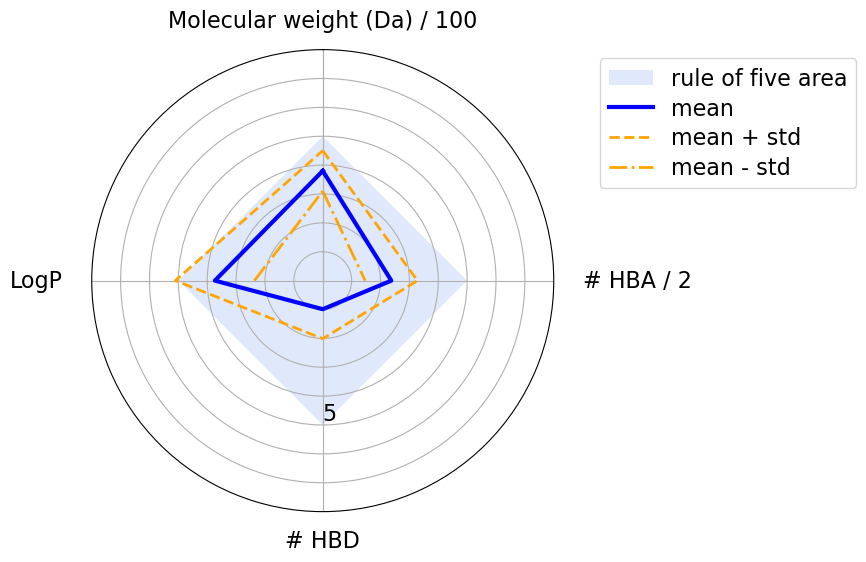

In [110]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

The blue square shows the area where a molecule's physicochemical properties are compliant with the Ro5. 
The blue line highlights the mean values, while the orange dashed lines show the standard deviations. 
We can see that the mean values never violate any of Lipinski's rules. 
However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. 
This is acceptable because, according to the Ro5, one of the four rules can be violated.

2. We plot the radarplot for the dataset of compounds that __violate the Ro5__.

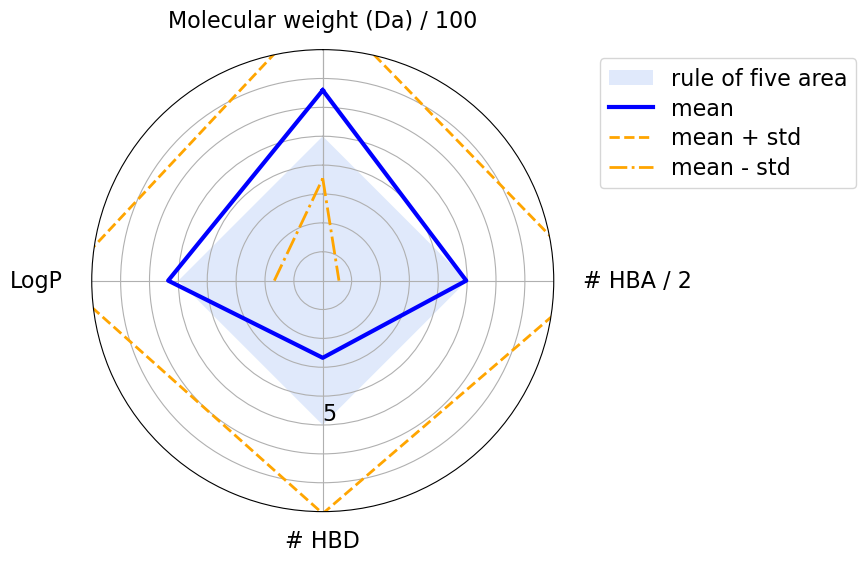

In [111]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

We see that compounds mostly violate the Ro5 because of their logP values and their molecular weight.

## Discussion

In this talktorial, we have learned about Lipinski's Ro5 as a measure to estimate a compound's oral bioavailability and we have applied the rule on a dataset using `rdkit`.
Note that drugs can also be administered via alternative routes, i.e. inhalation, skin penetration and injection. 

In this talktorial, we have looked at only one of many more ADME properties. Webservers such as [SwissADME](https://www.nature.com/articles/srep42717) give a more comprehensive view on compound properties.

## Quiz
* In what way can the chemical properties described by the Ro5 affect ADME?
* Find or design a molecule which violates three or four rules. 
* How can you plot information for an additional molecule in the radar charts that we have created in this talktorial?

# 3 Machine learning

### Load compound and activity data

Let's start by loading our data, which focuses on the Epidermal growth factor receptor (EGFR) kinase. The *csv* file from **Talktorial T002** is loaded into a dataframe with the important columns:

* CHEMBL-ID
* SMILES string of the corresponding compound
* Measured affinity: pIC50

In [112]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    "COX2_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3749, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL297008,60.00,nM,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,311.098000,3,0,3.85622,True
1,CHEMBL289813,3230.00,nM,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,357.083493,4,0,3.80782,True
2,CHEMBL43736,80.00,nM,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,469.091470,4,0,6.22772,True
3,CHEMBL140167,0.12,nM,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,335.148556,0,1,6.38170,True
4,CHEMBL44290,1610.00,nM,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,371.099143,4,0,4.19792,True


In [113]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174


### Data preparation

#### Data labeling
We need to classify each compound as active or inactive. Therefore, we use the pIC50 value.

* pIC50 = -log10(IC50) 
* IC50 describes the amount of substance needed to inhibit, _in vitro_, a process by 50% .
* A common cut-off value to discretize pIC50 data is 6.3, which we will use for our experiment (refer to [<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611) and the corresponding
[notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb))
* Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature or even to define an exclusion range when not to take data points. 

In [114]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 1695
Number of inactive compounds: 2054


In [115]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,1.0
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,0.0


#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we incorporated the choice between the following fingerprints:

* maccs
* morgan2 and morgan3

In [116]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    # if method == 'morganX':
    #     mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    #     return np.array(mfpgen.GetFingerprint(smiles))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [117]:
compound_df = chembl_df.copy()

In [118]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

Additionally, we will comment on the results.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function `model_training_and_validation` which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set. We also plot the ROC curves using `plot_roc_curves_for_models`.

We then define a function named `crossvalidation` which executes a cross validation procedure and prints the statistics of the results over the folds.

#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [119]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [120]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [121]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [122]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2999
Test data size: 750


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [123]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [124]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.78
Specificity: 0.80
AUC: 0.86


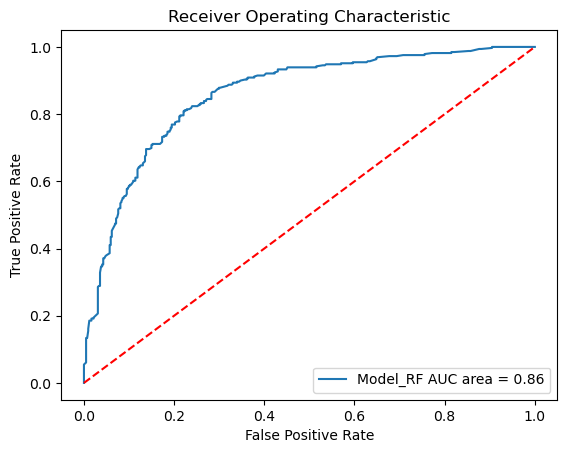

In [125]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [126]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.77
Specificity: 0.82
AUC: 0.86


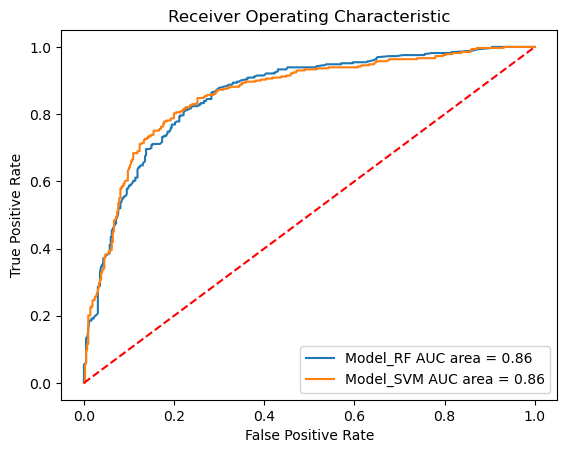

In [127]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 2 layers: the first layer with 5 neurons and the second layer with 3 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [128]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.68
Specificity: 0.82
AUC: 0.81


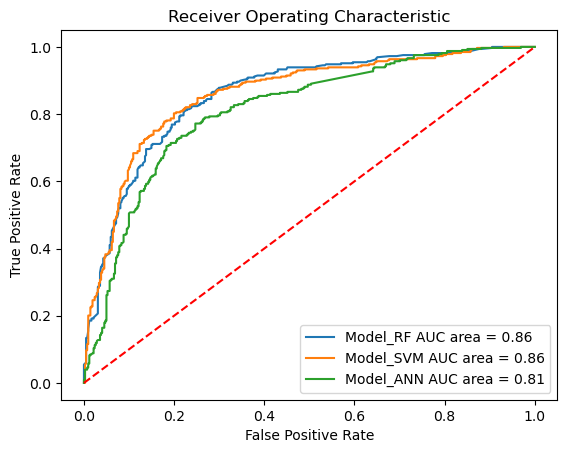

In [129]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [130]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [131]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [132]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.80 	and std : 0.00 
Mean sensitivity: 0.77 	and std : 0.00 
Mean specificity: 0.83 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.00 
Time taken : 1.60s


Model_SVM
Mean accuracy: 0.81 	and std : 0.00 
Mean sensitivity: 0.77 	and std : 0.01 
Mean specificity: 0.84 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.00 
Time taken : 13.42s


Model_ANN
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.71 	and std : 0.02 
Mean specificity: 0.80 	and std : 0.02 
Mean AUC: 0.82 	and std : 0.01 
Time taken : 62.59s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [133]:
# Reset data frame
compound_df = chembl_df.copy()

In [134]:
%%capture
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

_Note_: Next cell takes long to execute

In [135]:
for model in models:
    #if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        #continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.78 	and std : 0.01 
Mean specificity: 0.83 	and std : 0.02 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 5.91s


Model_SVM
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.59 	and std : 0.03 
Mean specificity: 0.91 	and std : 0.02 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 217.29s


Model_ANN
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.75 	and std : 0.01 
Mean specificity: 0.77 	and std : 0.03 
Mean AUC: 0.83 	and std : 0.01 
Time taken : 251.90s



In [136]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pIC50.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pIC50.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [137]:
compound_df

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,7.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,5.490797,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,7.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,9.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL44290,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,5.793174,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
4014,CHEMBL5290904,CS(=O)(=O)c1ccc(-c2cn3c(c2-c2ccccc2)CCC3)cc1,7.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4015,CHEMBL5277274,COC1c2c(-c3ccccc3)c(-c3ccc(Cl)cc3)c(C)n2CC1(C)C,5.124939,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4016,CHEMBL5272932,Cc1ccc(-c2cn3c(c2-c2ccccc2)CCC3)s1,5.744727,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4017,CHEMBL4472111,CCOC(=O)[C@H](CO)NC(=O)c1cccc(O)c1O,5.653647,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [138]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pIC50.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2999
Test data size: 750


In [139]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.61 	and std : 0.01 
RMSE: 0.82 	and std : 0.02 



You will notice that we report different measures of accuracy. We no longer deal with categorical data so we now look at the errors between experimental data and predicted data using the MAE and RMSE. Typically, an MAE below 0.6 and/or RMSE below, approximately, is considered quite decent.

Next, let's use the RF model to run predictions on a new compound. You can design your compounds in a sketcher (chemdraw (https://chemdrawdirect.perkinelmer.cloud/js/sample/index.html#) or an online tool).

In [140]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
    
    'CCC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3', 
    'CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3',
    'NS(=O)(=O)c3ccc(C1=C(CN=O)ONC1c2ccccc2)cc3'
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
CCC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,7.05
CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,7.17
NS(=O)(=O)c3ccc(C1=C(CN=O)ONC1c2ccccc2)cc3,6.62


[11:18:53] DEPRECATION WARNING: please use MorganGenerator
[11:18:53] DEPRECATION WARNING: please use MorganGenerator
[11:18:53] DEPRECATION WARNING: please use MorganGenerator
